# DYNAMOL-NVT

# Clara Saad, Keïsha Hassen, Louise Antoine

Version 20201207 - Kyle Reeves (@kgreeves), Mathieu Salanne (@salanne)

This jupyter notebook allows to simulate a monoatomic system in the [canonical ensemble](https://en.wikipedia.org/wiki/Canonical_ensemble) (*NVT*) using [molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics).

The interactions are calculated using the [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) :

$$
V(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6 \right]
$$

It accounts for short-range repulsion and dispersion interactions only, so in practice we can only simulate noble gases.

## Projet 5 : Tension de surface de l'argon liquide

- Modifier le code afin de pouvoir simuler des boites non cubiques et calculer les valeurs diagonales du tenseur de pression *P_{xx}*, *P_{yy}* et *P_{zz}*
- Construire une boite contenant une tranche de vide assez épaisse selon une des trois directions (typiquement 5 fois plus épaisse que la tranche de liquide). On note *L* la longueur de la boite dans cette direction
- À l'aide de simulations dans l'ensemble *NVT*, se placer dans l'état liquide. La tension de surface est donnée par *\gamma = \frac{1}{2}L[P_{zz}-\frac{1}{2}(P_{xx}+P_{yy})]*

First we need to import the `numpy`, `matplotlib`, `numba`, `MDAnalysis` and `nglview` libraries:

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import numba

#For Visualization
import MDAnalysis
import nglview as nv
from nglview.datafiles import PDB, XTC

Then we define a series of parameters that will often be changed :
- `Nsteps` is the number of steps of the simulation
- `Nequil` is the number of steps for equilibration (the remaining steps are production)
- `Frequency_write_physical_properties` is the frequency at which the physical quantities are saved
- `Frequency_write_trajectories` is the frequency at which the trajectories are saved
- `Ngrid_rdf` defines the number of points for the computation of the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function)
- `Box_size` is the length of the cubic box edge; Box_sizeXY for X and Y axis and Box_sizeZ for Z axis
- `Temperature_imposed` is the imposed temperature during equilibration

In [33]:
Nsteps = 5000
Nequil = 1000
Frequency_write_physical_properties = 1
Frequency_write_trajectories = 10
Ngrid_rdf = 100
Box_sizeZ = 200.0 # On appelle Box_sizeZ la longueur L, 5 fois supérieure à Box_sizeXY
Box_sizeXY = 22.0 # for solid Ar at 0 K
Temperature_imposed = 100.0 #On se place à 100K pour être à l'état liquide

And a series of parameters that we should not change much :
- `Timestep_fs` is the timestep (in fs, 1 fs = 10$^{-15}$ s)
- `Thermostat_relaxation_time_fs` is the characteristic time of the thermostat (in fs)
- `Natoms` is the number of atoms (Warning! Changing this requires a few additional changes below)
- `Mass` is the atomic mass (in g mol$^{-1}$) of the simulated compound
- `Epsilon` is the $\epsilon$ parameter of the Lennard-Jones potential (in kJ mol$^{-1}$)
- `Sigma` is the $\sigma$ parameter of the Lennard-Jones potential (in $\unicode{x212B}$)

The initial settings correspond to the [Argon](https://www.webelements.com/argon/) atom.

In [34]:
Timestep_fs = 5.0
Thermostat_relaxation_time_fs = 100.0
Natoms = 512
Mass = 39.948
Epsilon = 0.9966288
Sigma = 3.405

We also need to define a few physical constants :

In [35]:
Avogadro = 6.022140857e23
Boltzmann = 1.38064852e-23
Bohr = 0.52917721067e-10
Pi = 3.14159265358979323

For consistency, all the computations are made in [atomic units](https://en.wikipedia.org/wiki/Hartree_atomic_units), then the results are plotted in conventional units. We therefore need define a series of conversion factors.

In [36]:
Time_fs2au = 1.0 / 2.4188843265857e-2
Length_Angstrom2au = 1.0e-10 / Bohr
Length_au2Angstrom = 1.0 / Length_Angstrom2au
Energy_au2J = 4.359744650e-18
Energy_J2au = 1.0 / Energy_au2J
Energy_kJpermol2au = 1.0e3 * Energy_J2au / Avogadro
Energy_au2kJpermol = 1.0 / Energy_kJpermol2au
Mass_gpermol2au = 1.0e-3 / (Avogadro * 9.10938356e-31)
Pressure_au2bar = 2.9421015697e8

Then we do all the corresponding conversions :

In [37]:
Box_sizeXY = Box_sizeXY * Length_Angstrom2au
Box_sizeZ = Box_sizeZ * Length_Angstrom2au
Epsilon = Epsilon * Energy_kJpermol2au
Sigma = Sigma * Length_Angstrom2au
Mass_au = Mass * Mass_gpermol2au 
Timestep = Timestep_fs * Time_fs2au
Boltzmann_au = Boltzmann * Energy_J2au

Finally before getting started we compute a few quantities (number of data points that will be accumulated, cut-off length, for the LJ interactions and interval for the calculation of the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function)).

In [38]:
Nwrite_physical_properties = int(Nsteps / Frequency_write_physical_properties)
Nwrite_physical_properties_equil = int(Nequil / Frequency_write_physical_properties)
Rcutoff = min( Box_sizeXY/2.0 , 2.5*Sigma )
Rcutoff2 = Rcutoff**2
Dr_rdf = Rcutoff/float(Ngrid_rdf)

Note that all the variables defined so far will not change until the end, they are therefore noted with capital letters. In the following we define several functions that will be used by the program.

**Function 1**: It computes the temperature and kinetic energy using the instantaneous velocities

### Because of the change of the box shape, the pressure and the kinetic energy will be not homogeneous throughout the box. We introduce the X, Y and Z components.

In [39]:
def Compute_Temperature(velocities):
    
    kinetic_energy = 0.0
    kinetic_energyX = 0.0
    kinetic_energyY = 0.0
    kinetic_energyZ = 0.0
    for i in range(Natoms) :
        kinetic_energy = kinetic_energy + 0.5*Mass_au*np.dot(velocities[i,:],velocities[i,:])
        kinetic_energyX = kinetic_energyX + 0.5*Mass_au*np.dot(velocities[i,:],velocities[i,:])
        kinetic_energyY = kinetic_energyY + 0.5*Mass_au*np.dot(velocities[i,:],velocities[i,:])
        kinetic_energyZ = kinetic_energyZ + 0.5*Mass_au*np.dot(velocities[i,:],velocities[i,:])
        #kinetic_energyX + kinetic_energyY + kinetic_energyZ = kinetic_energy
       
        
        
    temperature = 2.0 * kinetic_energy / (3.0 * Boltzmann_au * Natoms)


    configurational_pressure = 2.0 * kinetic_energy / (3.0 * Box_sizeXY**2 *Box_sizeZ)
    configurational_pressureX = 2.0 * kinetic_energyX / (3.0 * Box_sizeXY**2 *Box_sizeZ)
    configurational_pressureY = 2.0 * kinetic_energyY / (3.0 * Box_sizeXY**2 *Box_sizeZ)
    configurational_pressureZ = 2.0 * kinetic_energyZ / (3.0 * Box_sizeXY**2 *Box_sizeZ)
    #configurational_pressureX + configurational_pressureY + configurational_pressureZ =configurational_pressure
    
    
    return (kinetic_energy, temperature, configurational_pressure, configurational_pressureX, configurational_pressureY, configurational_pressureZ)
    #we do not return kinetic_energy for X, Y and Z axis because we do not need them outside this definition.

**Function 2**: It computes the long-range correction on the energy and pressure due to the use of a cut-off in the Lennard-Jones potential

In [40]:
def Compute_long_range_corrections():

    long_range_correction_energy = 4.0 * Epsilon * Sigma**3 * Natoms**2 * ((Sigma/Rcutoff)**9/3.0 -(Sigma/Rcutoff)**3)
    long_range_correction_energy = long_range_correction_energy * 2.0 * Pi / (3.0 * Box_sizeXY**2 *Box_sizeZ)

    long_range_correction_pressure = 4.0 * Epsilon * Sigma**3 * Natoms**2 * ((Sigma/Rcutoff)**9*4.0 - (Sigma/Rcutoff)**3*6.0)
    long_range_correction_pressure = long_range_correction_pressure * 2.0 * Pi / (3.0 * Box_sizeXY**2 *Box_sizeZ)

    long_range_correction_pressure = long_range_correction_pressure / (3.0 * Box_sizeXY**2 *Box_sizeZ)

    return long_range_correction_energy, long_range_correction_pressure

**Function 3**: It computes the forces, the virial and the potential energy of the system using the instantaneous positions. This is where most of the computational cost of the program lies due to the double-loop over the atoms. The  distance histograms necessary to calculate the [radial distribution function](https://en.wikipedia.org/wiki/Radial_distribution_function) are also accumulated here.

In [41]:
@numba.njit
def lj_terms(r):  
    attractive_term = (Sigma/r)**6
    repulsive_term = attractive_term**2
    return attractive_term, repulsive_term

@numba.njit
def lj_force(rsquare,attractive_term, repulsive_term):
    fij = 4.0 * Epsilon * (12.0*repulsive_term-6.0*attractive_term)/rsquare
    return fij

@numba.njit
def lj_energy(attractive_term, repulsive_term):
    potential_energy = 4.0 * Epsilon * (repulsive_term - attractive_term)
    return potential_energy

@numba.njit
def distance(ri,rj):
    dx = ri[0] - rj[0]
    dy = ri[1] - rj[1]
    dz = ri[2] - rj[2]
    if(dx > Box_sizeXY/2.0):
        dx = dx - Box_sizeXY
    if(dx < -Box_sizeXY/2.0):
        dx = dx + Box_sizeXY
    if(dy > Box_sizeXY/2.0):
        dy = dy - Box_sizeXY
    if(dy < -Box_sizeXY/2.0):
        dy = dy + Box_sizeXY
    if(dz > Box_sizeZ/2.0):
        dz = dz - Box_sizeZ
    if(dz < -Box_sizeZ/2.0):
        dz = dz + Box_sizeZ  
    r2 = dx*dx + dy*dy + dz*dz
    r  = r2 ** 0.5
    return dx, dy, dz, r, r2

@numba.njit(parallel=True)
def Compute_Forces(positions,rdf):

    potential_energy = 0.0 
    virial = 0.0
    virialX = 0.0
    virialY = 0.0
    virialZ = 0.0
    forces = np.zeros((Natoms,3))

    for i in range(Natoms-1) :
        for j in range(i+1,Natoms) :
            dx,dy,dz,rijdist,rijsquare = distance(positions[i,:],positions[j,:])
            if(rijsquare < Rcutoff2):
                rdf[int(rijdist/Dr_rdf)] += 1.0
                attractive_term, repulsive_term = lj_terms(rijdist)
                fij = lj_force(rijsquare,attractive_term, repulsive_term)
                energyij = lj_energy(attractive_term, repulsive_term)
                potential_energy = potential_energy +  energyij
                forces[i,0] = forces[i,0] + fij*dx
                forces[j,0] = forces[j,0] - fij*dx
                forces[i,1] = forces[i,1] + fij*dy
                forces[j,1] = forces[j,1] - fij*dy
                forces[i,2] = forces[i,2] + fij*dz
                forces[j,2] = forces[j,2] - fij*dz                
                virial = virial + 4.0 * Epsilon * (12.0*repulsive_term-6.0*attractive_term)
                virialX = virialX + fij*dx*dx  #we introduce X, Y and Z components, as we did for pressure and energy
                virialY = virialY + fij*dy*dy  # virialX + virialY + virialZ = virial
                virialZ = virialZ + fij*dz*dz

    virial = virial/(3.0*Box_sizeXY**2 *Box_sizeZ)
    virialX = virialX/(3.0*Box_sizeXY**2 *Box_sizeZ)
    virialY = virialY/(3.0*Box_sizeXY**2 *Box_sizeZ)
    virialZ = virialZ/(3.0*Box_sizeXY**2 *Box_sizeZ)

    return potential_energy, forces, virialX, virialY, virialZ, rdf

**Function 4**: It performs the first half of the [velocity-Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet), in which the new positions and the temporary new velocities are computed

In [42]:
def Verlet_halfstep1(positions, velocities, forces):
    
    newpositions = positions + velocities * Timestep + 0.5*Timestep**2*forces/Mass_au
    newvelocities = velocities + 0.5*Timestep*forces/Mass_au

    return newpositions, newvelocities

**Function 5**: It performs the second half of the [velocity-Verlet algorithm](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet), in which the new velocities are computed

In [43]:
def Verlet_halfstep2(velocities, forces):

    newvelocities = velocities + 0.5*Timestep*forces/Mass_au

    return newvelocities

**Function 6**: The positions are initialized by placing the atoms on a [face-centered cubic lattice](https://en.wikipedia.org/wiki/Close-packing_of_equal_spheres#FCC_and_HCP_Lattices) replicated three times along each direction

In [44]:
def initialize_positions():

    origin = np.zeros([3])
    initial_positions = np.zeros([Natoms,3])
    shift = Box_sizeXY / 4.0 #we shift in relation to Box_sizeXY because we want a vacuum space in the box.

    origin[0] = 0.0
    origin[1] = 0.0
    origin[2] = 0.0

    l = 0
    for i in range (4) :
        for j in range (4) :
            for k in range (8) :
            #We create more liquid to avoid interactions between particles. These cause temperature anormal increases.
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.5
    origin[1] = 0.5
    origin[2] = 0.0
    origin = origin * shift

    for i in range (4) :
        for j in range (4) :
            for k in range (8) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.5
    origin[1] = 0.0
    origin[2] = 0.5
    origin = origin * shift

    for i in range (4) :
        for j in range (4) :
            for k in range (8) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    origin[0] = 0.0
    origin[1] = 0.5
    origin[2] = 0.5
    origin = origin * shift

    for i in range (4) :
        for j in range (4) :
            for k in range (8) :
                initial_positions[l,0] = origin[0] + i*shift
                initial_positions[l,1] = origin[1] + j*shift
                initial_positions[l,2] = origin[2] + k*shift  
                l = l+1

    return initial_positions

**Function 7**: It applies [periodic boundary conditions](https://en.wikipedia.org/wiki/Periodic_boundary_conditions) by putting back the atoms inside the main cell

In [45]:
def inside_box(positions):

    for i in range(Natoms) :
            if(positions[i,0] > Box_sizeXY) :
                positions[i,0] = positions[i,0] - Box_sizeXY
            if(positions[i,0] < 0.0) :
                positions[i,0] = positions[i,0] + Box_sizeXY
            if(positions[i,1] > Box_sizeXY) :
                positions[i,1] = positions[i,1] - Box_sizeXY
            if(positions[i,1] < 0.0) :
                positions[i,1] = positions[i,1] + Box_sizeXY
            if(positions[i,2] > Box_sizeZ) : #empêche la superposition des atomes
                positions[i,2] = positions[i,2] - Box_sizeZ
            if(positions[i,2] < 0.0) :
                positions[i,2] = positions[i,2] + Box_sizeZ 
#périodicité des atomes: quand un atome dépasse de la box d'un côté, cette définition permet de renvoyer l'atome de l'autre
#côté de la box. Le milieu, rempli de vide, est toujours respecté car il s'agit d'une infinité de tranches périodiques,
#il n'y a pas qu'une seule tranche.
    return positions

**Function 8**: It removes the center of mass velocity to avoid the [flying ice cube effect](https://en.wikipedia.org/wiki/Flying_ice_cube)

In [46]:
def remove_com_velocity(velocities):

    velocity_com = np.zeros([3])
    for i in range(Natoms) :
        velocity_com[:] = velocity_com[:] + velocities[i,:]

    velocity_com = velocity_com / Natoms

    for i in range(Natoms) :
        velocities[i,:] = velocities[i,:] - velocity_com[:]

    return velocities

**Function 9**: It performs velocity rescaling in order to equal the instantaneous temperature to the target one

In [47]:
def rescale_velocities(velocities):

    
    temperature = Compute_Temperature(velocities)[1]
    
    scaling_factor_squared = 1.0 + (Timestep_fs / Thermostat_relaxation_time_fs) * (Temperature_imposed / temperature - 1.0)
    scaling_factor = np.sqrt(scaling_factor_squared)
    
    scaled_velocities = velocities * scaling_factor
            

    return scaled_velocities

**Function 10**: Velocities are initialized according to a random distribution, then the center of mass velocity is removed (by calling **Function 8**) and the velocities are rescaled (by calling **Function 9**)

In [48]:
def initialize_velocities():

    initial_velocities = np.random.normal(0,0.001,[Natoms,3])
    initial_velocities = remove_com_velocity(initial_velocities)
    temperature = Compute_Temperature(initial_velocities)[1]
    initial_velocities = initial_velocities * np.sqrt(Temperature_imposed / temperature)

    return initial_velocities

**Function 11**: It creates arrays for all the physical properties (temperature, pressure, kinetic, potential and total energies, radial distribution functions) that will be computed during the simulation

In [49]:
def initialize_physical_properties():

    temperature = np.zeros([Nwrite_physical_properties])
    pressure = np.zeros([Nwrite_physical_properties])
    pressureX = np.zeros([Nwrite_physical_properties])
    pressureY = np.zeros([Nwrite_physical_properties])
    pressureZ = np.zeros([Nwrite_physical_properties])

    kinetic_energy = np.zeros([Nwrite_physical_properties])
    kinetic_energyX = np.zeros([Nwrite_physical_properties])
    kinetic_energyY = np.zeros([Nwrite_physical_properties])
    kinetic_energyZ = np.zeros([Nwrite_physical_properties])
    
    potential_energy = np.zeros([Nwrite_physical_properties])
    total_energy = np.zeros([Nwrite_physical_properties])
    rdf = np.zeros([Ngrid_rdf])
    time = np.zeros([Nwrite_physical_properties])

    return temperature, pressureX, pressureY, pressureZ, kinetic_energy, potential_energy, total_energy, rdf, time

__Function 12:__ Used to prepare the trajectory data to be visualized.

In [50]:
def Generate_MD_Traj(Natoms,AtomNames,Box_sizeXY, Box_sizeZ,Coordinates):
    
    #In the case of a gas, residues are notapplicable here.
    Nresidues = Natoms
    
    #Generate the "Universe" which defines the systems (Natoms and AtomNames)
    U1 = MDAnalysis.Universe.empty(Natoms,
                                   Nresidues,
                                   atom_resindex=np.arange(Nresidues),
                                   residue_segindex=[0]*Nresidues,
                                   trajectory=True,
                                  )
    
    #U1.triclinic_dimensions = [[Box_sizeXY,0,0],[0,Box_sizeXY,0],[0,0,Box_sizeZ]]

    #Additional Information that should be defined to complete "Universe." Many of these values are
    #just dummy values. "Type" is the most relevant parameter defining the element type.
    U1.add_TopologyAttr('name',[str(AtomNames)]*Nresidues)
    U1.add_TopologyAttr('type',[str(AtomNames)]*Nresidues) # Element Type
    U1.add_TopologyAttr('resnames',[str(AtomNames)]*Nresidues)
    U1.add_TopologyAttr('resid',list(range(1,Nresidues+1)))
    U1.add_TopologyAttr('segid',['DUMMY'])
    
    

    #Assign positions from an np.array of trajectory coordinates
    U1.load_new(np.array(Coordinates), order='fac')
    U1.dimensions = np.array([Box_sizeXY,Box_sizeXY,Box_sizeZ,90,90,90])

    return U1

def Visualize_Trajectory(MD_Universe):
    
    #Generates the object that is ultimately returned and visualized
    U1_view = nv.show_mdanalysis(MD_Universe)
    U1_view.add_representation('spacefill', selection='all',color='#660066',opacity=0.75)

    #Paramters used to make the system easier to see. Background color, perspective, shadows, etc.
    U1_view.add_unitcell()
    U1_view.camera = 'orthographic'
    U1_view.center()
    U1_view.parameters = {
    # "percentages, "dist" is distance too camera in Angstrom
    "clipNear": 20, "clipFar": 90, "clipDist": 10,
    # percentages, start of fog and where on full effect
    "fogNear": 20, "fogFar": 90,
    # background color
    "backgroundColor": "#F5F5F5",
}
    return U1_view

The main program may be splitted in three parts:
- An initialization in which starting values are assigned to the positions and velocities, and the various arrays are created
- An equilibration phase during which the velocities are rescaled at each step
- A production phase during which the system should sample equilibrium configurations only. It is during this phase that we will accumulate the physical properties

In [51]:
## Initialization
coords_MD= [] 
positions = initialize_positions()
velocities = initialize_velocities()
temperature, pressureX, pressureY, pressureZ, kinetic_energy, potential_energy, total_energy, rdf, time = initialize_physical_properties()
long_range_correction_energy, long_range_correction_pressure = Compute_long_range_corrections() 

forces = Compute_Forces(positions, rdf) [1]

k = 0
kwrite = 0
## Integrate equations of motion -- equilibration
for i in range(Nequil) :
    positions, velocities = Verlet_halfstep1(positions, velocities, forces)
    positions = inside_box(positions)
    locpotential_energy, forces, virialX, virialY, virialZ, rdf = Compute_Forces(positions, rdf)
    velocities = Verlet_halfstep2(velocities, forces)
    velocities = remove_com_velocity(velocities)
    velocities = rescale_velocities(velocities) 
#   pressure = virial + conf_pressure + long_range_correction_pressure
    if (np.mod(k+1,Frequency_write_physical_properties) == 0) :
        lockinetic_energy, temperature[kwrite], conf_pressure, conf_pressureX, conf_pressureY, conf_pressureZ = Compute_Temperature(velocities)
        potential_energy[kwrite] = locpotential_energy + long_range_correction_energy
        potential_energy[kwrite] = potential_energy[kwrite] * Energy_au2kJpermol
        kinetic_energy[kwrite] = lockinetic_energy * Energy_au2kJpermol
        total_energy[kwrite] = kinetic_energy[kwrite]+ potential_energy[kwrite]
        #pressure[kwrite] = virial + conf_pressure
        pressureX[kwrite] = virialX + conf_pressureX
        pressureY[kwrite] = virialY + conf_pressureY
        pressureZ[kwrite] = virialZ + conf_pressureZ
        #pressure[kwrite] = pressure[kwrite] * Pressure_au2bar
        pressureX[kwrite] = pressureX[kwrite] * Pressure_au2bar
        pressureY[kwrite] = pressureY[kwrite] * Pressure_au2bar
        pressureZ[kwrite] = pressureZ[kwrite] * Pressure_au2bar
        time[kwrite] = Frequency_write_physical_properties * kwrite * Timestep_fs 
        kwrite = kwrite + 1
    if (np.mod(k+1,Frequency_write_trajectories) == 0) : 
        coords_MD.append(positions)
    k = k + 1   

# We need to reinitialize the accumulation of the rdf to account for production stage only    
rdf = np.zeros([Ngrid_rdf])    
    
## Integrate equations of motion -- production
for i in range(Nsteps-Nequil) :
    positions, velocities = Verlet_halfstep1(positions, velocities, forces)
    positions = inside_box(positions)
    locpotential_energy, forces, virialX,virialY,virialZ, rdf = Compute_Forces(positions, rdf)
    velocities = Verlet_halfstep2(velocities, forces)
    velocities = remove_com_velocity(velocities)
    velocities = rescale_velocities(velocities)
#   pressure = virial + conf_pressure + long_range_correction_pressure
    if (np.mod(k+1,Frequency_write_physical_properties) == 0) :
        lockinetic_energy, temperature[kwrite], conf_pressure, conf_pressureX, conf_pressureY, conf_pressureZ = Compute_Temperature(velocities)
        potential_energy[kwrite] = locpotential_energy + long_range_correction_energy
        potential_energy[kwrite] = potential_energy[kwrite] * Energy_au2kJpermol
        kinetic_energy[kwrite] = lockinetic_energy * Energy_au2kJpermol
        total_energy[kwrite] = kinetic_energy[kwrite] + potential_energy[kwrite]
        #pressure[kwrite] = virial + conf_pressure
        pressureX[kwrite] = virialX + conf_pressureX
        pressureY[kwrite] = virialY + conf_pressureY
        pressureZ[kwrite] = virialZ + conf_pressureZ
        #pressure[kwrite] = pressure[kwrite] * Pressure_au2bar
        pressureX[kwrite] = pressureX[kwrite] * Pressure_au2bar
        pressureY[kwrite] = pressureY[kwrite] * Pressure_au2bar
        pressureZ[kwrite] = pressureZ[kwrite] * Pressure_au2bar
        time[kwrite] = Frequency_write_physical_properties * kwrite * Timestep_fs
        kwrite = kwrite + 1
    if (np.mod(k+1,Frequency_write_trajectories) == 0) : 
        coords_MD.append(positions)        
    k = k + 1


print('Average temperature during production was',np.mean(temperature[Nwrite_physical_properties_equil:]),' K')
print('Average pressureX during production was',np.mean(pressureX[Nwrite_physical_properties_equil:]),' bar')
print('Average pressureY during production was',np.mean(pressureY[Nwrite_physical_properties_equil:]),' bar')
print('Average pressureZ during production was',np.mean(pressureZ[Nwrite_physical_properties_equil:]),' bar')

Average temperature during production was 99.6502585123867  K
Average pressureX during production was 38.99829039560116  bar
Average pressureY during production was 37.137127749551134  bar
Average pressureZ during production was 37.8998827936539  bar


In [52]:
print('Average total energy during production was',np.mean(total_energy[Nwrite_physical_properties_equil:]),' kJ/mol')

Average total energy during production was -1439.736419737811  kJ/mol


On calcule gamma en fonction des pressions X, Y et Z et de la taille L de la Box.

In [53]:
gamma = 1/2 * Box_sizeZ * ( (np.mean(pressureZ[Nwrite_physical_properties_equil:])) - 1/2*((np.mean(pressureX[Nwrite_physical_properties_equil:]))+np.mean(pressureY[Nwrite_physical_properties_equil:])))

print('La valeur de gamma est', gamma, ' N/m.' )


La valeur de gamma est -31.714570381774575  N/m.


Once the simulation is made we can visualize the various results. First we can have a look at the various energies

Text(0, 0.5, 'E (kJ mol^{-1})')

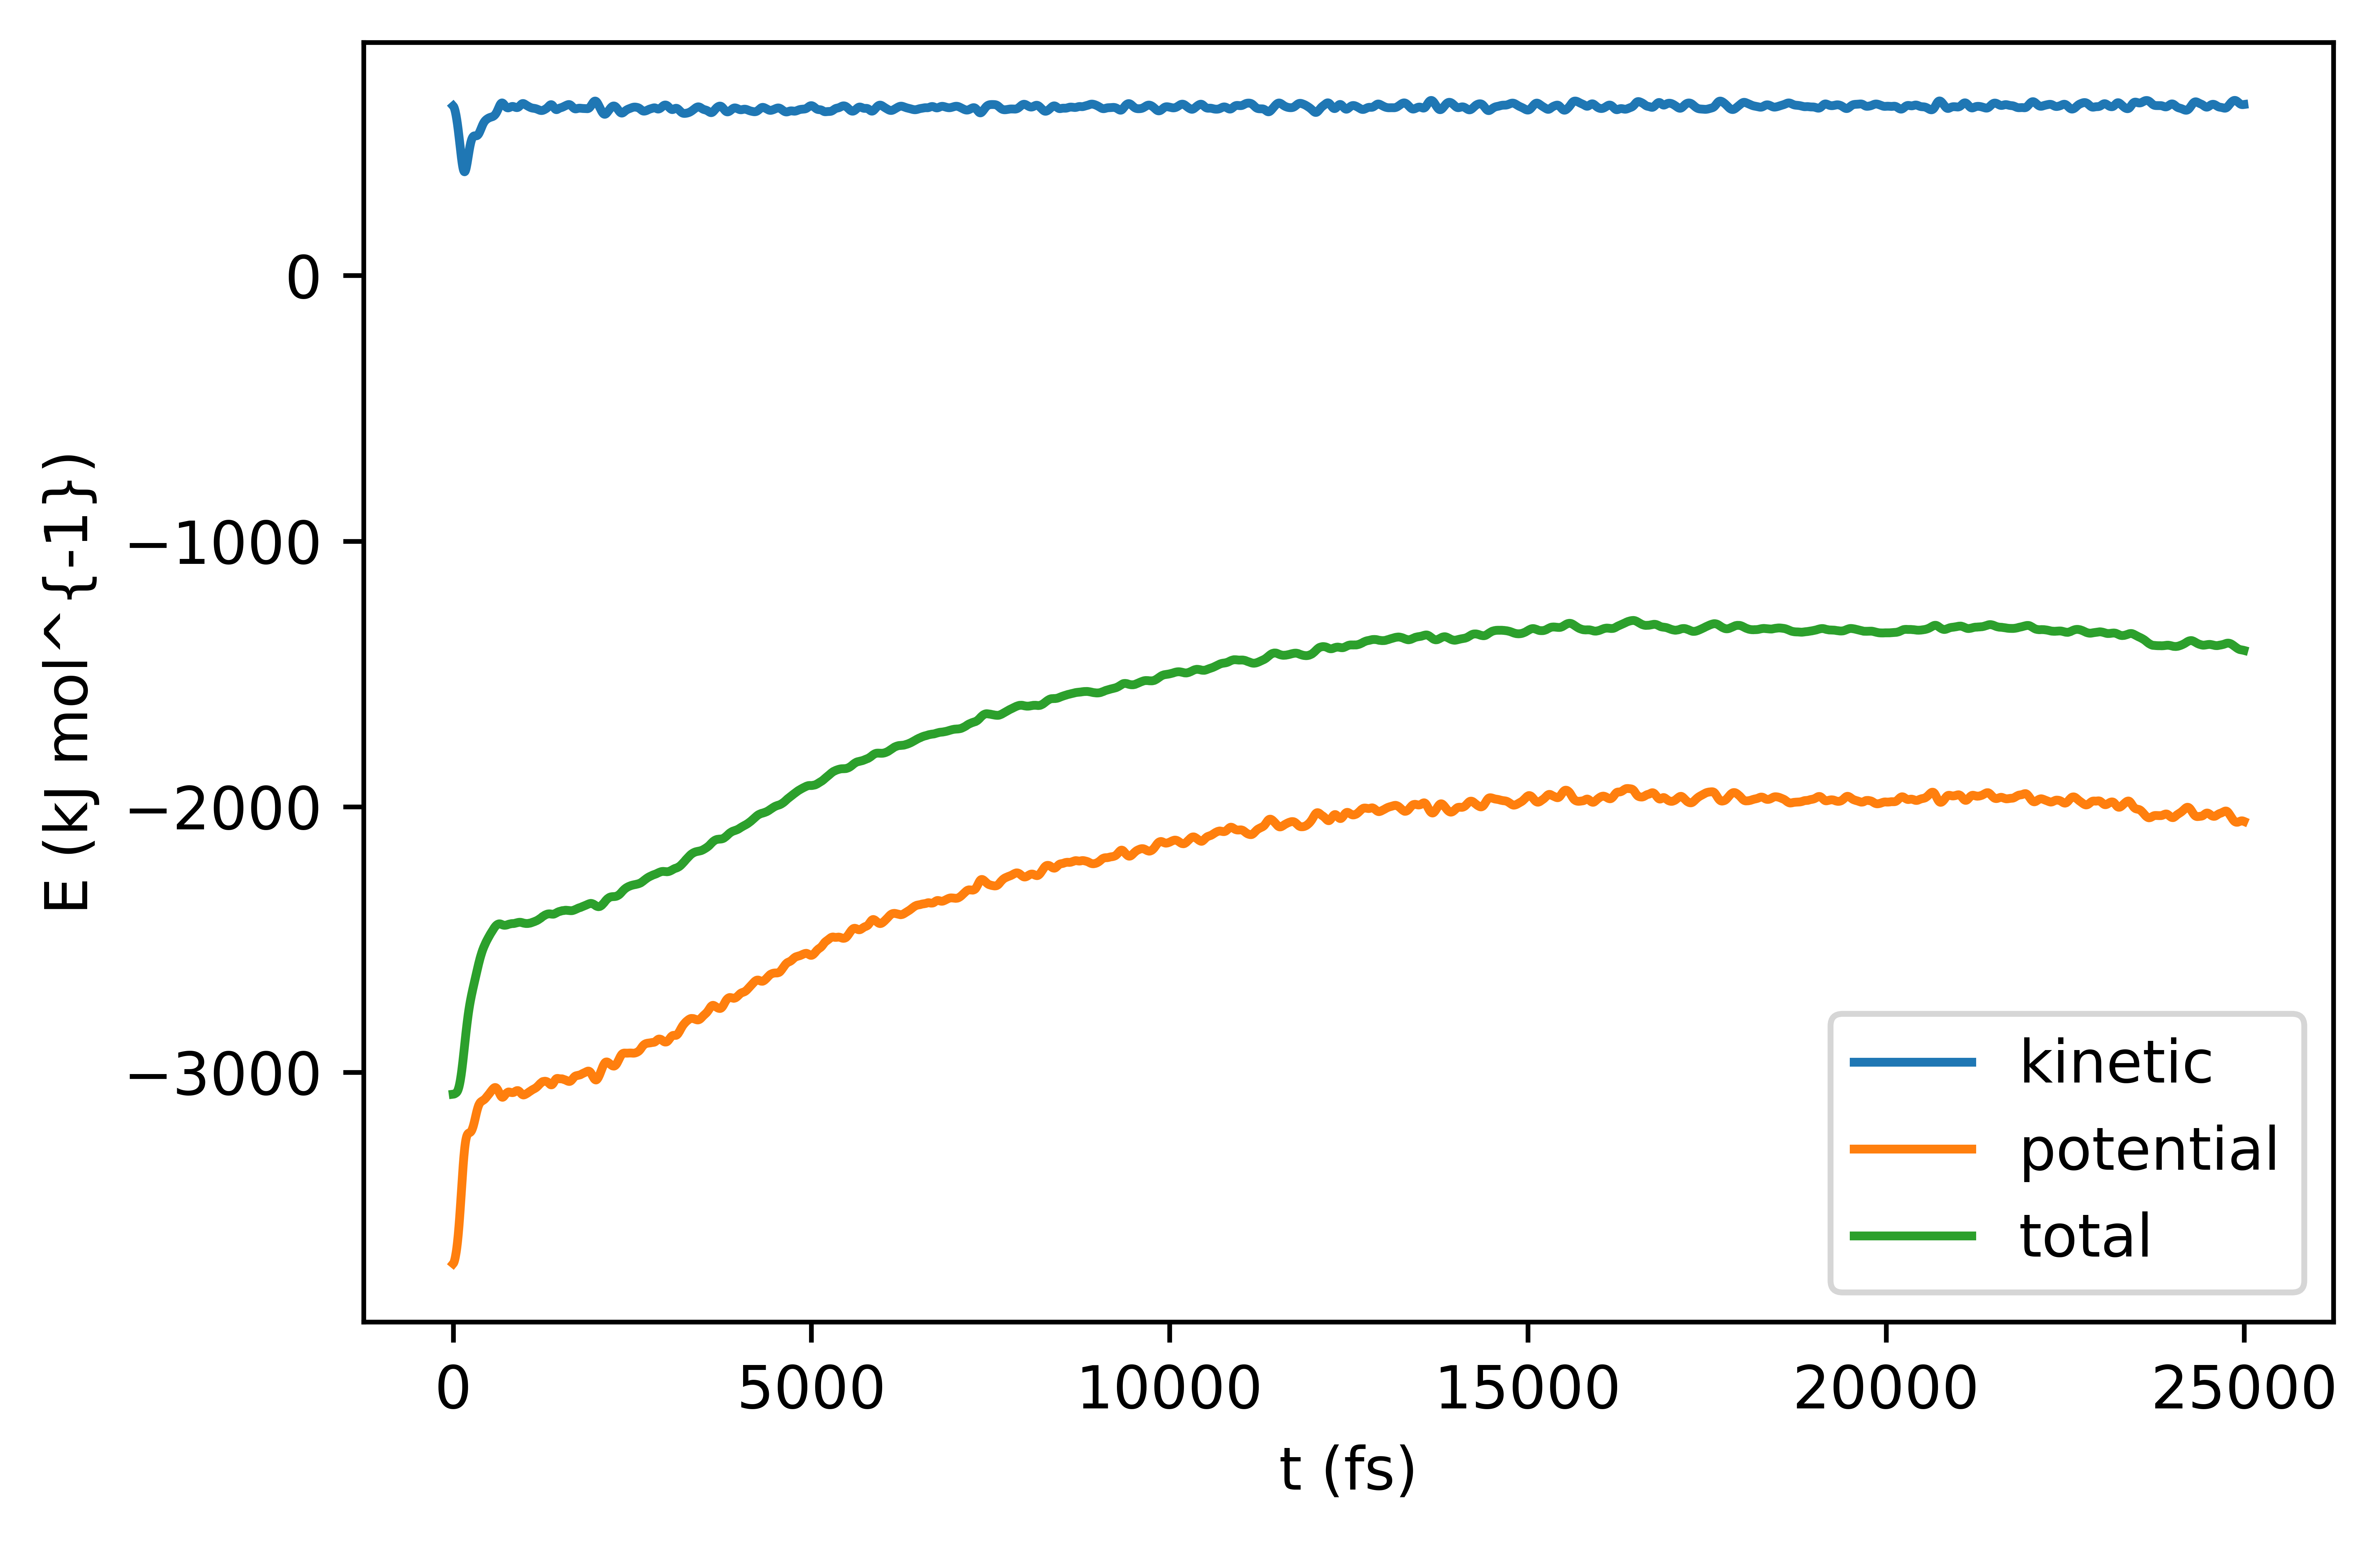

In [54]:
plt.figure(dpi=1200)
plt.rc('text', usetex=False)
plt.plot(time,kinetic_energy, label="kinetic")
plt.plot(time,potential_energy, label="potential")
plt.plot(time,total_energy, label="total")
plt.legend()
plt.xlabel(r't (fs)')
plt.ylabel(r'E (kJ mol^{-1})')

Text(0, 0.5, 'E (kJ mol^{-1})')

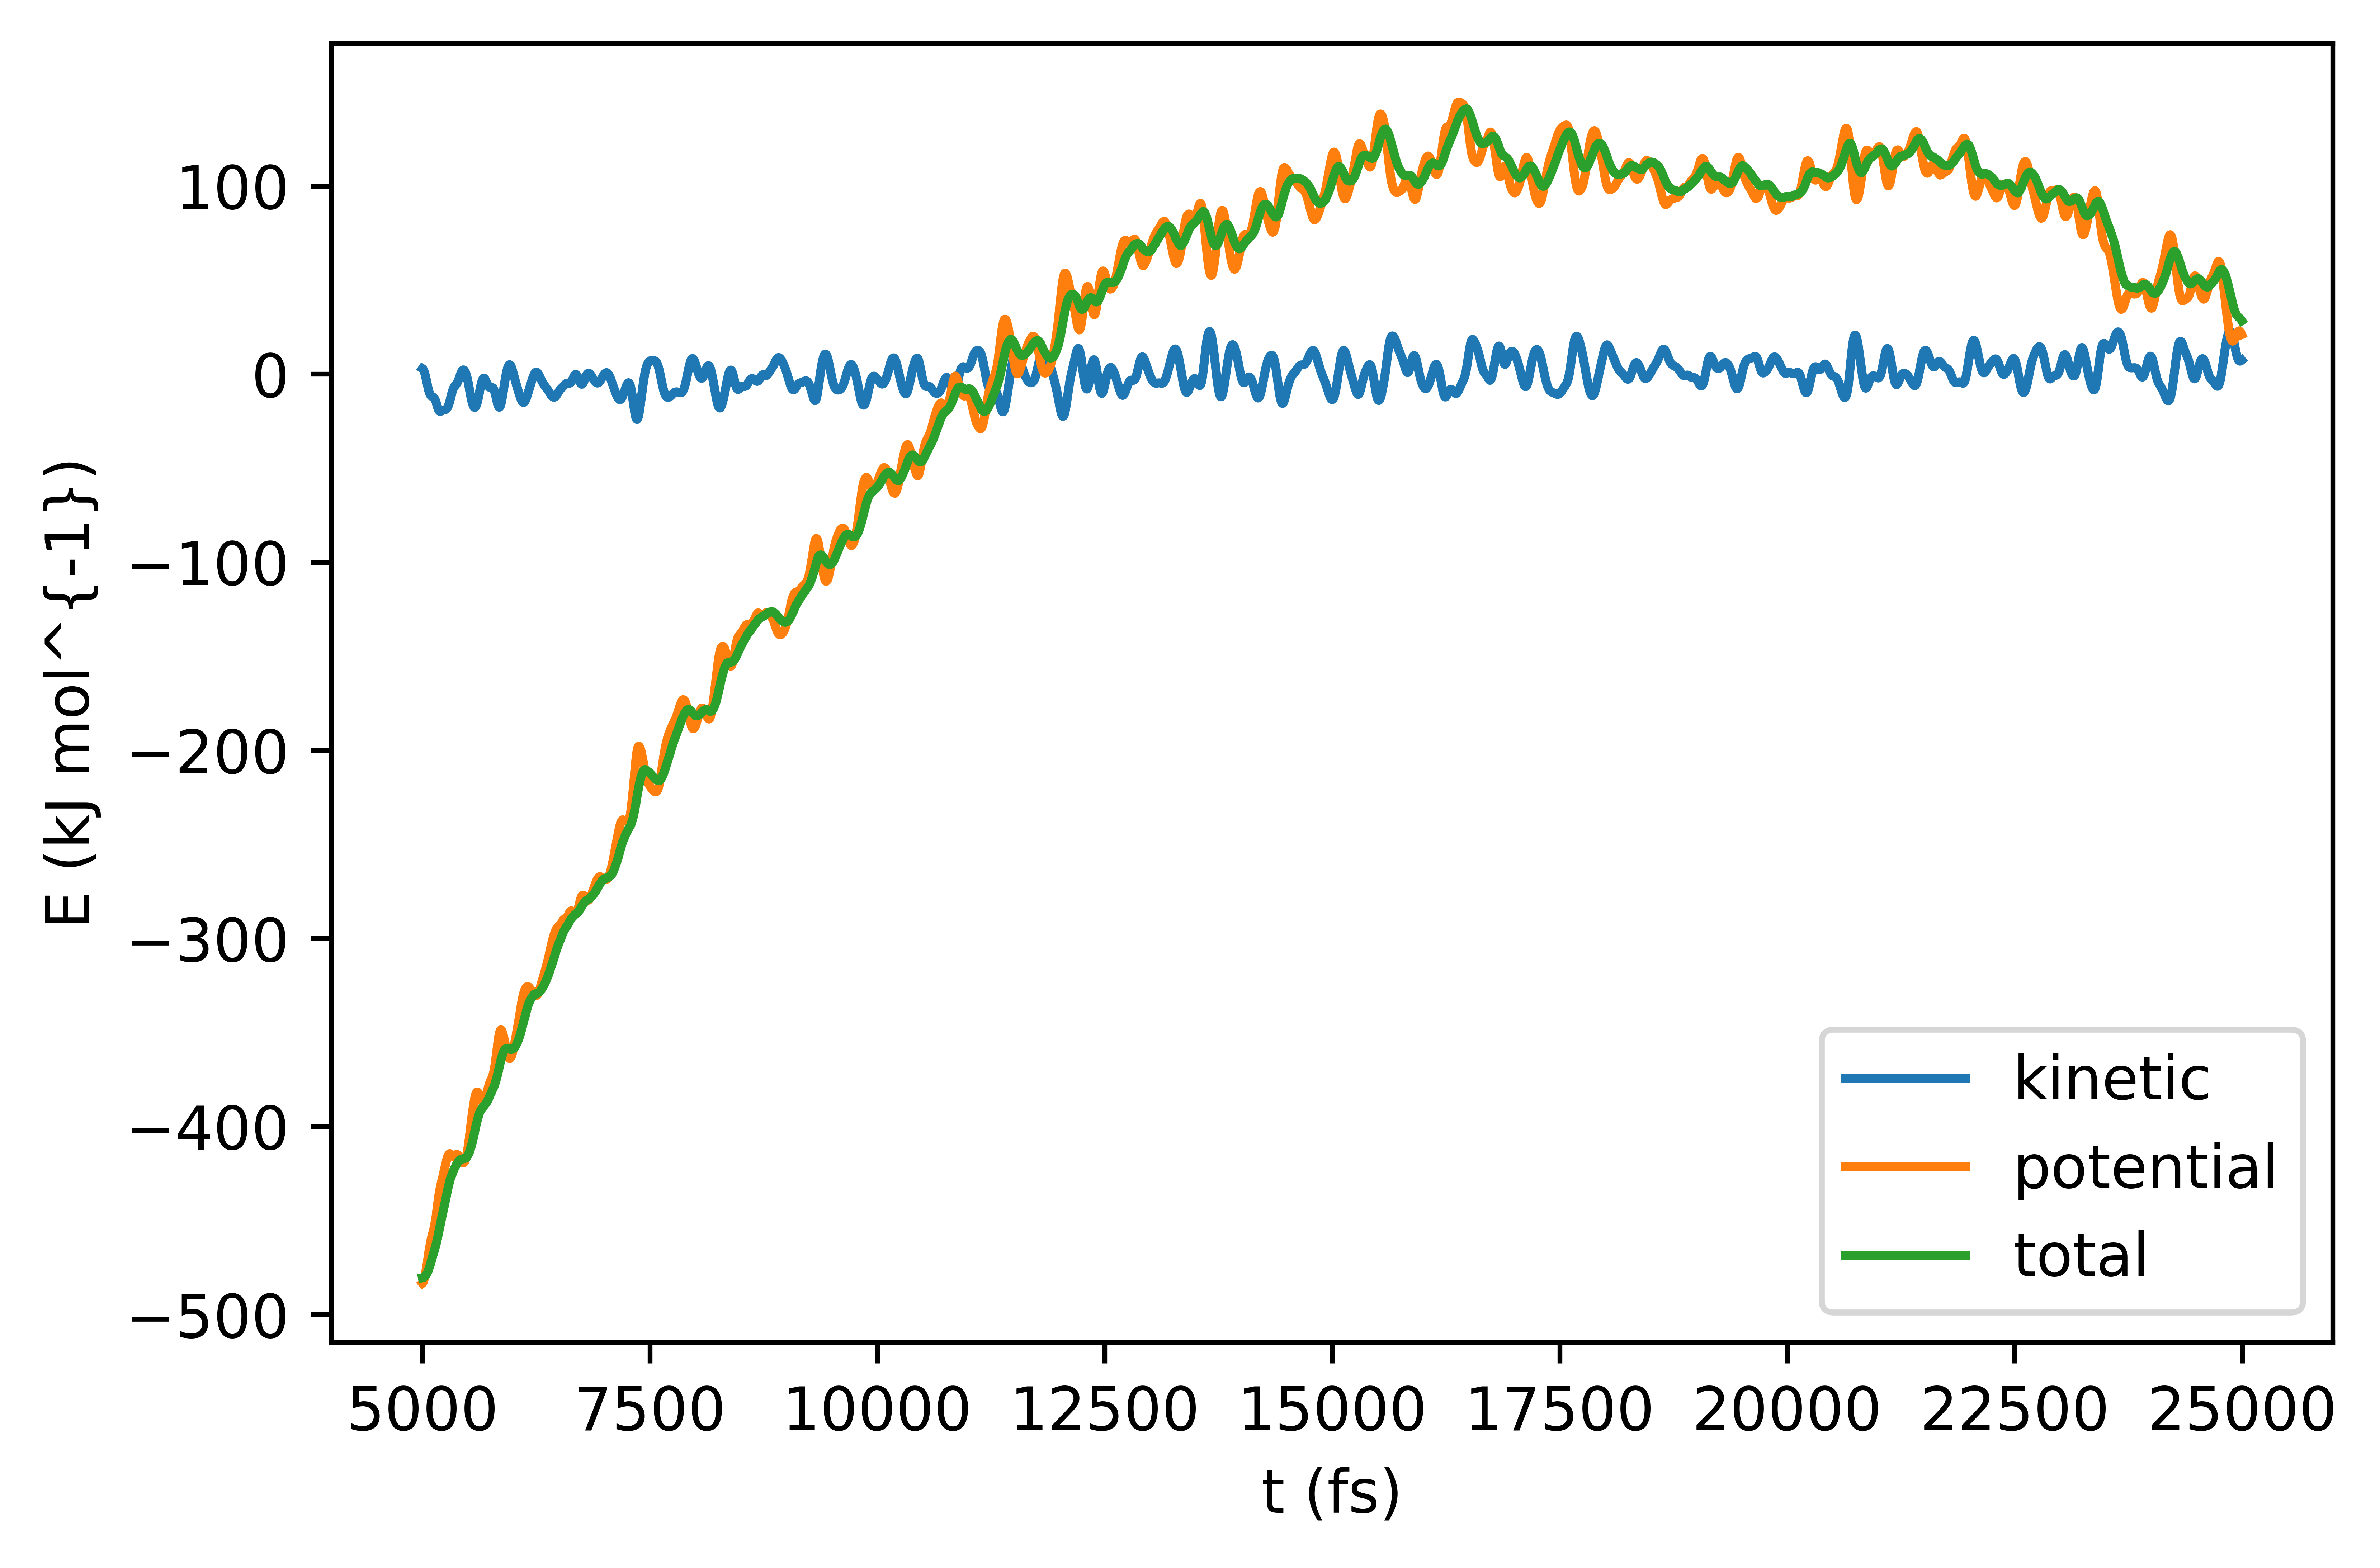

In [55]:
plt.figure(dpi=1200)
plt.rc('text', usetex=False)
mean_et = np.mean(total_energy[Nwrite_physical_properties_equil:])
mean_ep = np.mean(potential_energy[Nwrite_physical_properties_equil:])
mean_ek = np.mean(kinetic_energy[Nwrite_physical_properties_equil:])
plt.plot(time[Nwrite_physical_properties_equil:],kinetic_energy[Nwrite_physical_properties_equil:]-mean_ek, label="kinetic")
plt.plot(time[Nwrite_physical_properties_equil:],potential_energy[Nwrite_physical_properties_equil:]-mean_ep, label="potential")
plt.plot(time[Nwrite_physical_properties_equil:],total_energy[Nwrite_physical_properties_equil:]-mean_et, label="total")
plt.legend()
plt.xlabel(r't (fs)')
plt.ylabel(r'E (kJ mol^{-1})')

Same for the temperature

Text(0, 0.5, 'T (K)')

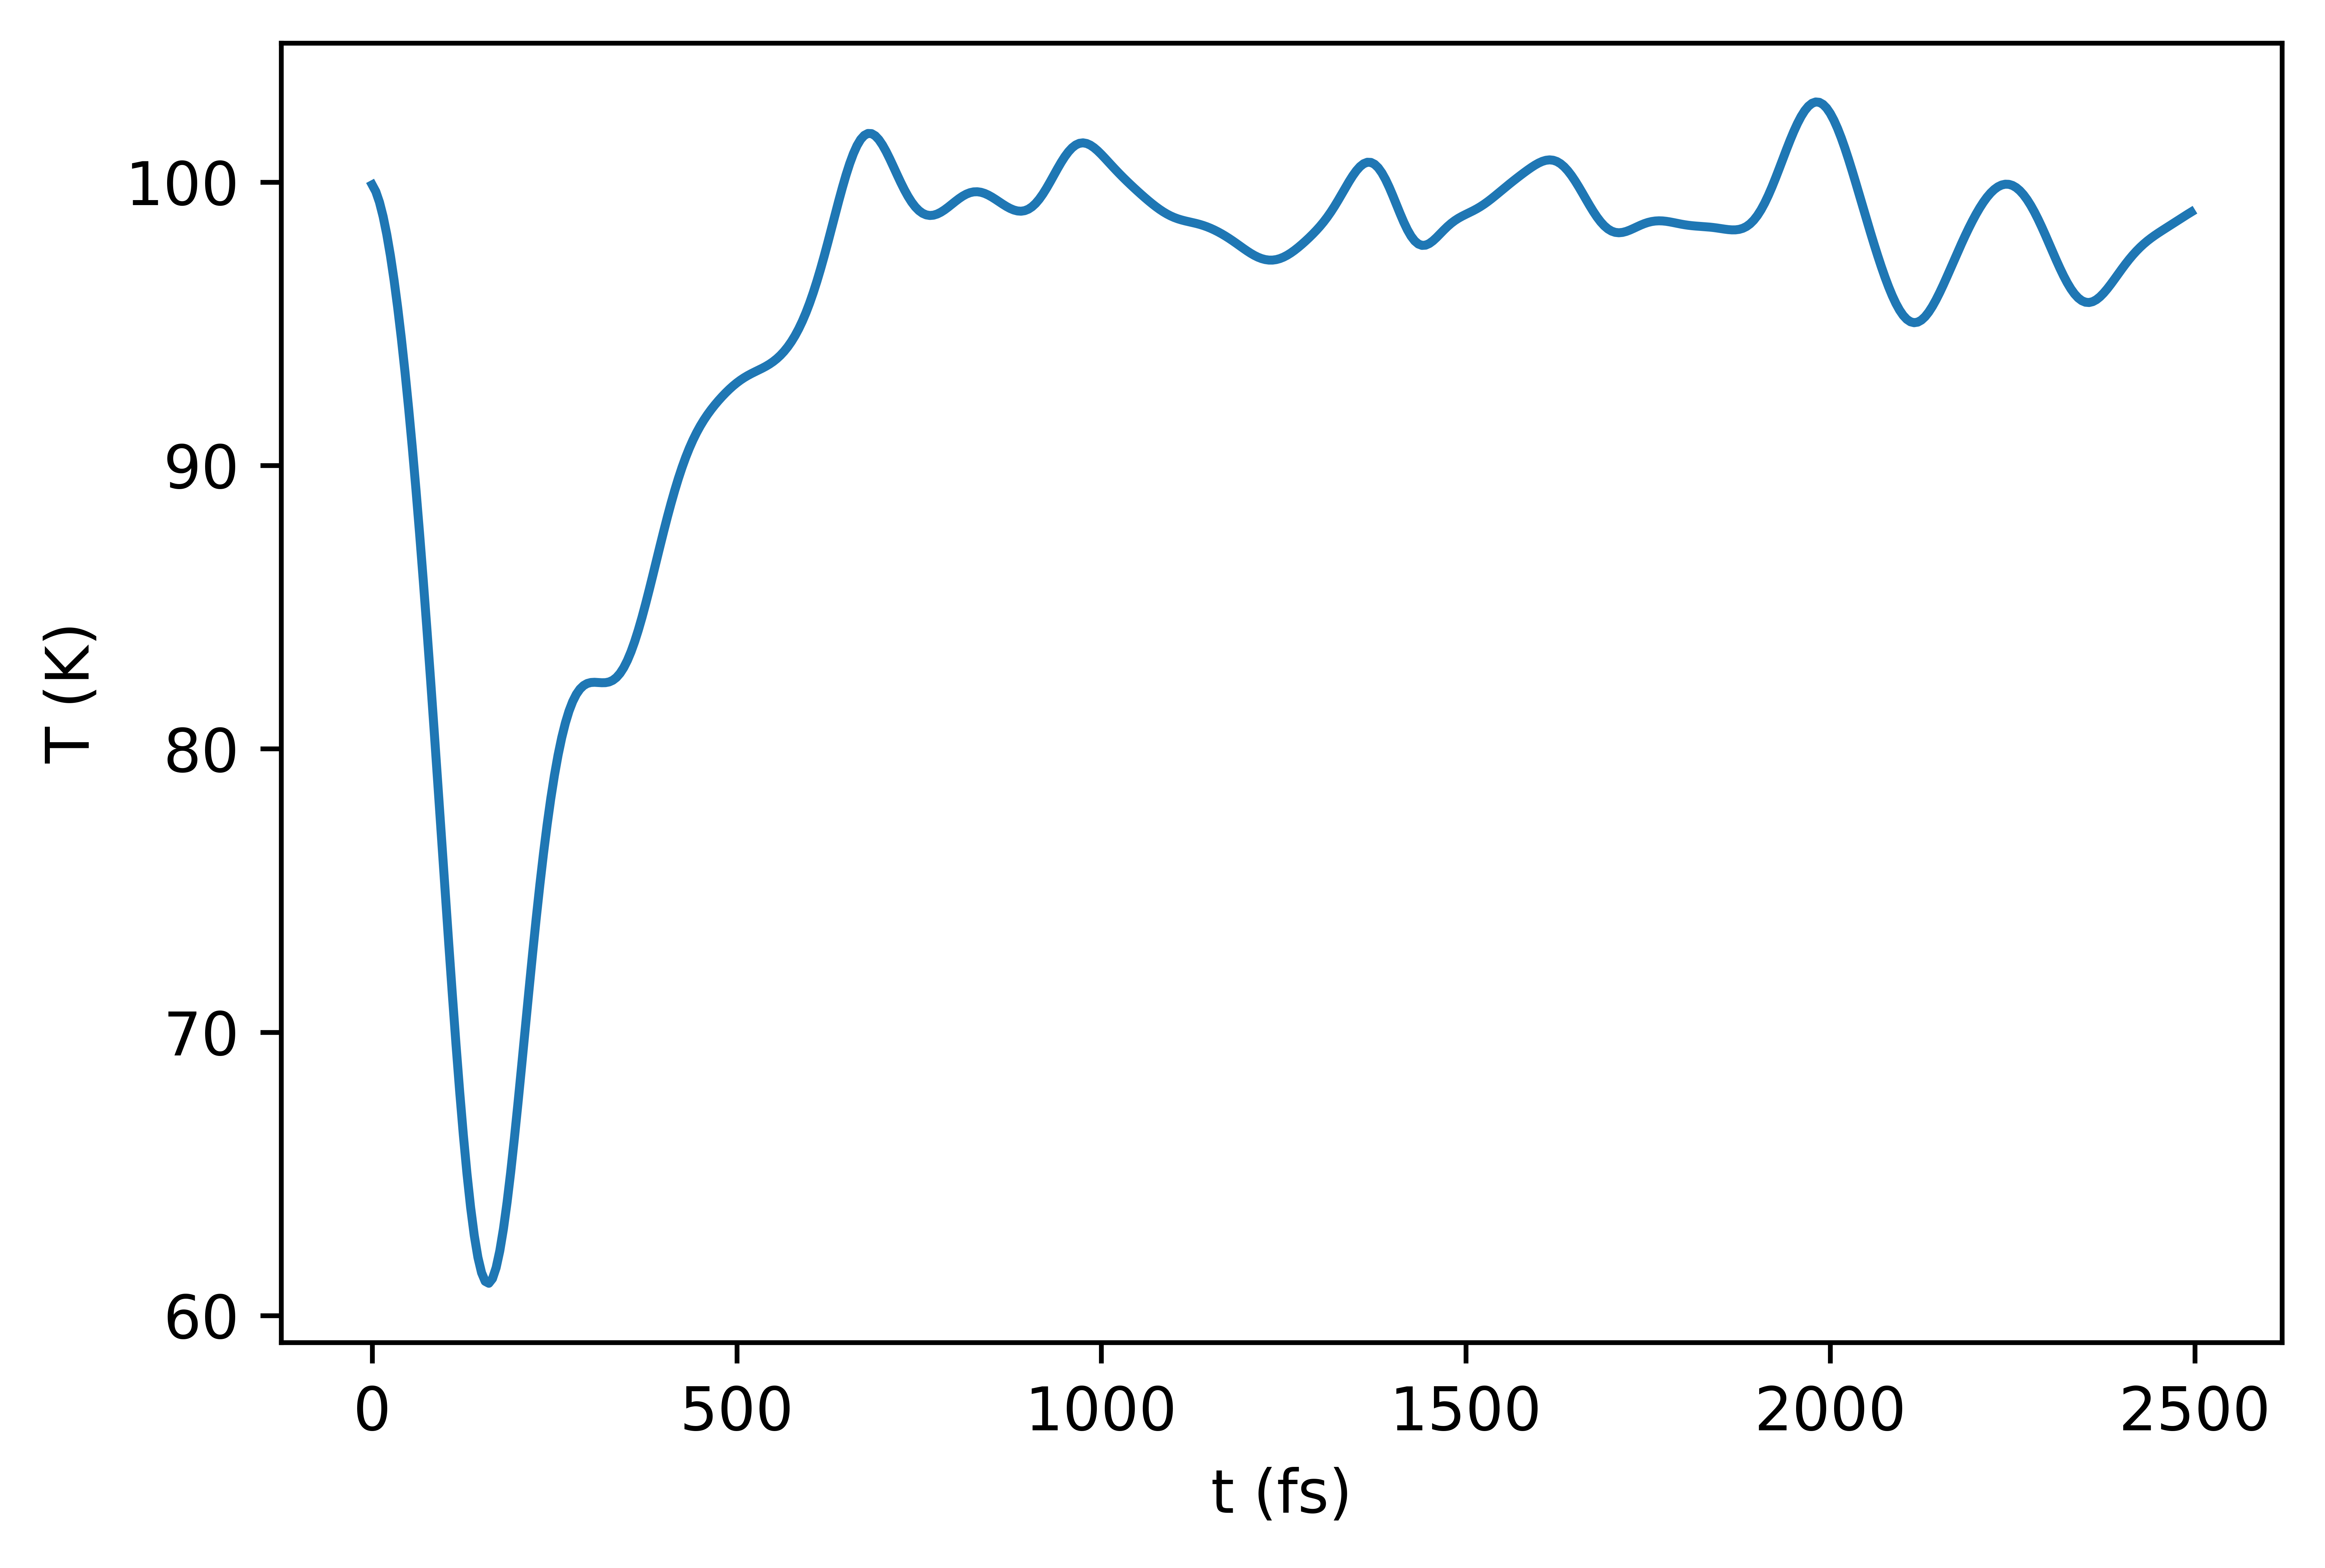

In [56]:
plt.figure(dpi=1200)
plt.rc('text', usetex=False)
plt.plot(time [0:500],temperature [0:500])
plt.xlabel(r't (fs)')
plt.ylabel(r'T (K)')

We can visualize the positions that are collected in `coords_MD`. First we need to convert from a `NumPy` array to a data structure that can be used with `nglview`. Here, the coordinates will be imported using `MDAnalysis`.

In [57]:
U1 = Generate_MD_Traj(Natoms,'Ar',Box_sizeXY, Box_sizeZ,coords_MD)

In [58]:
show_simulation = Visualize_Trajectory(U1)
show_simulation

NGLWidget(max_frame=499)

We can also plot the [radial distribution functions](https://en.wikipedia.org/wiki/Radial_distribution_function) which provide important information on the structure of the system

Text(0, 0.5, 'g(r)')

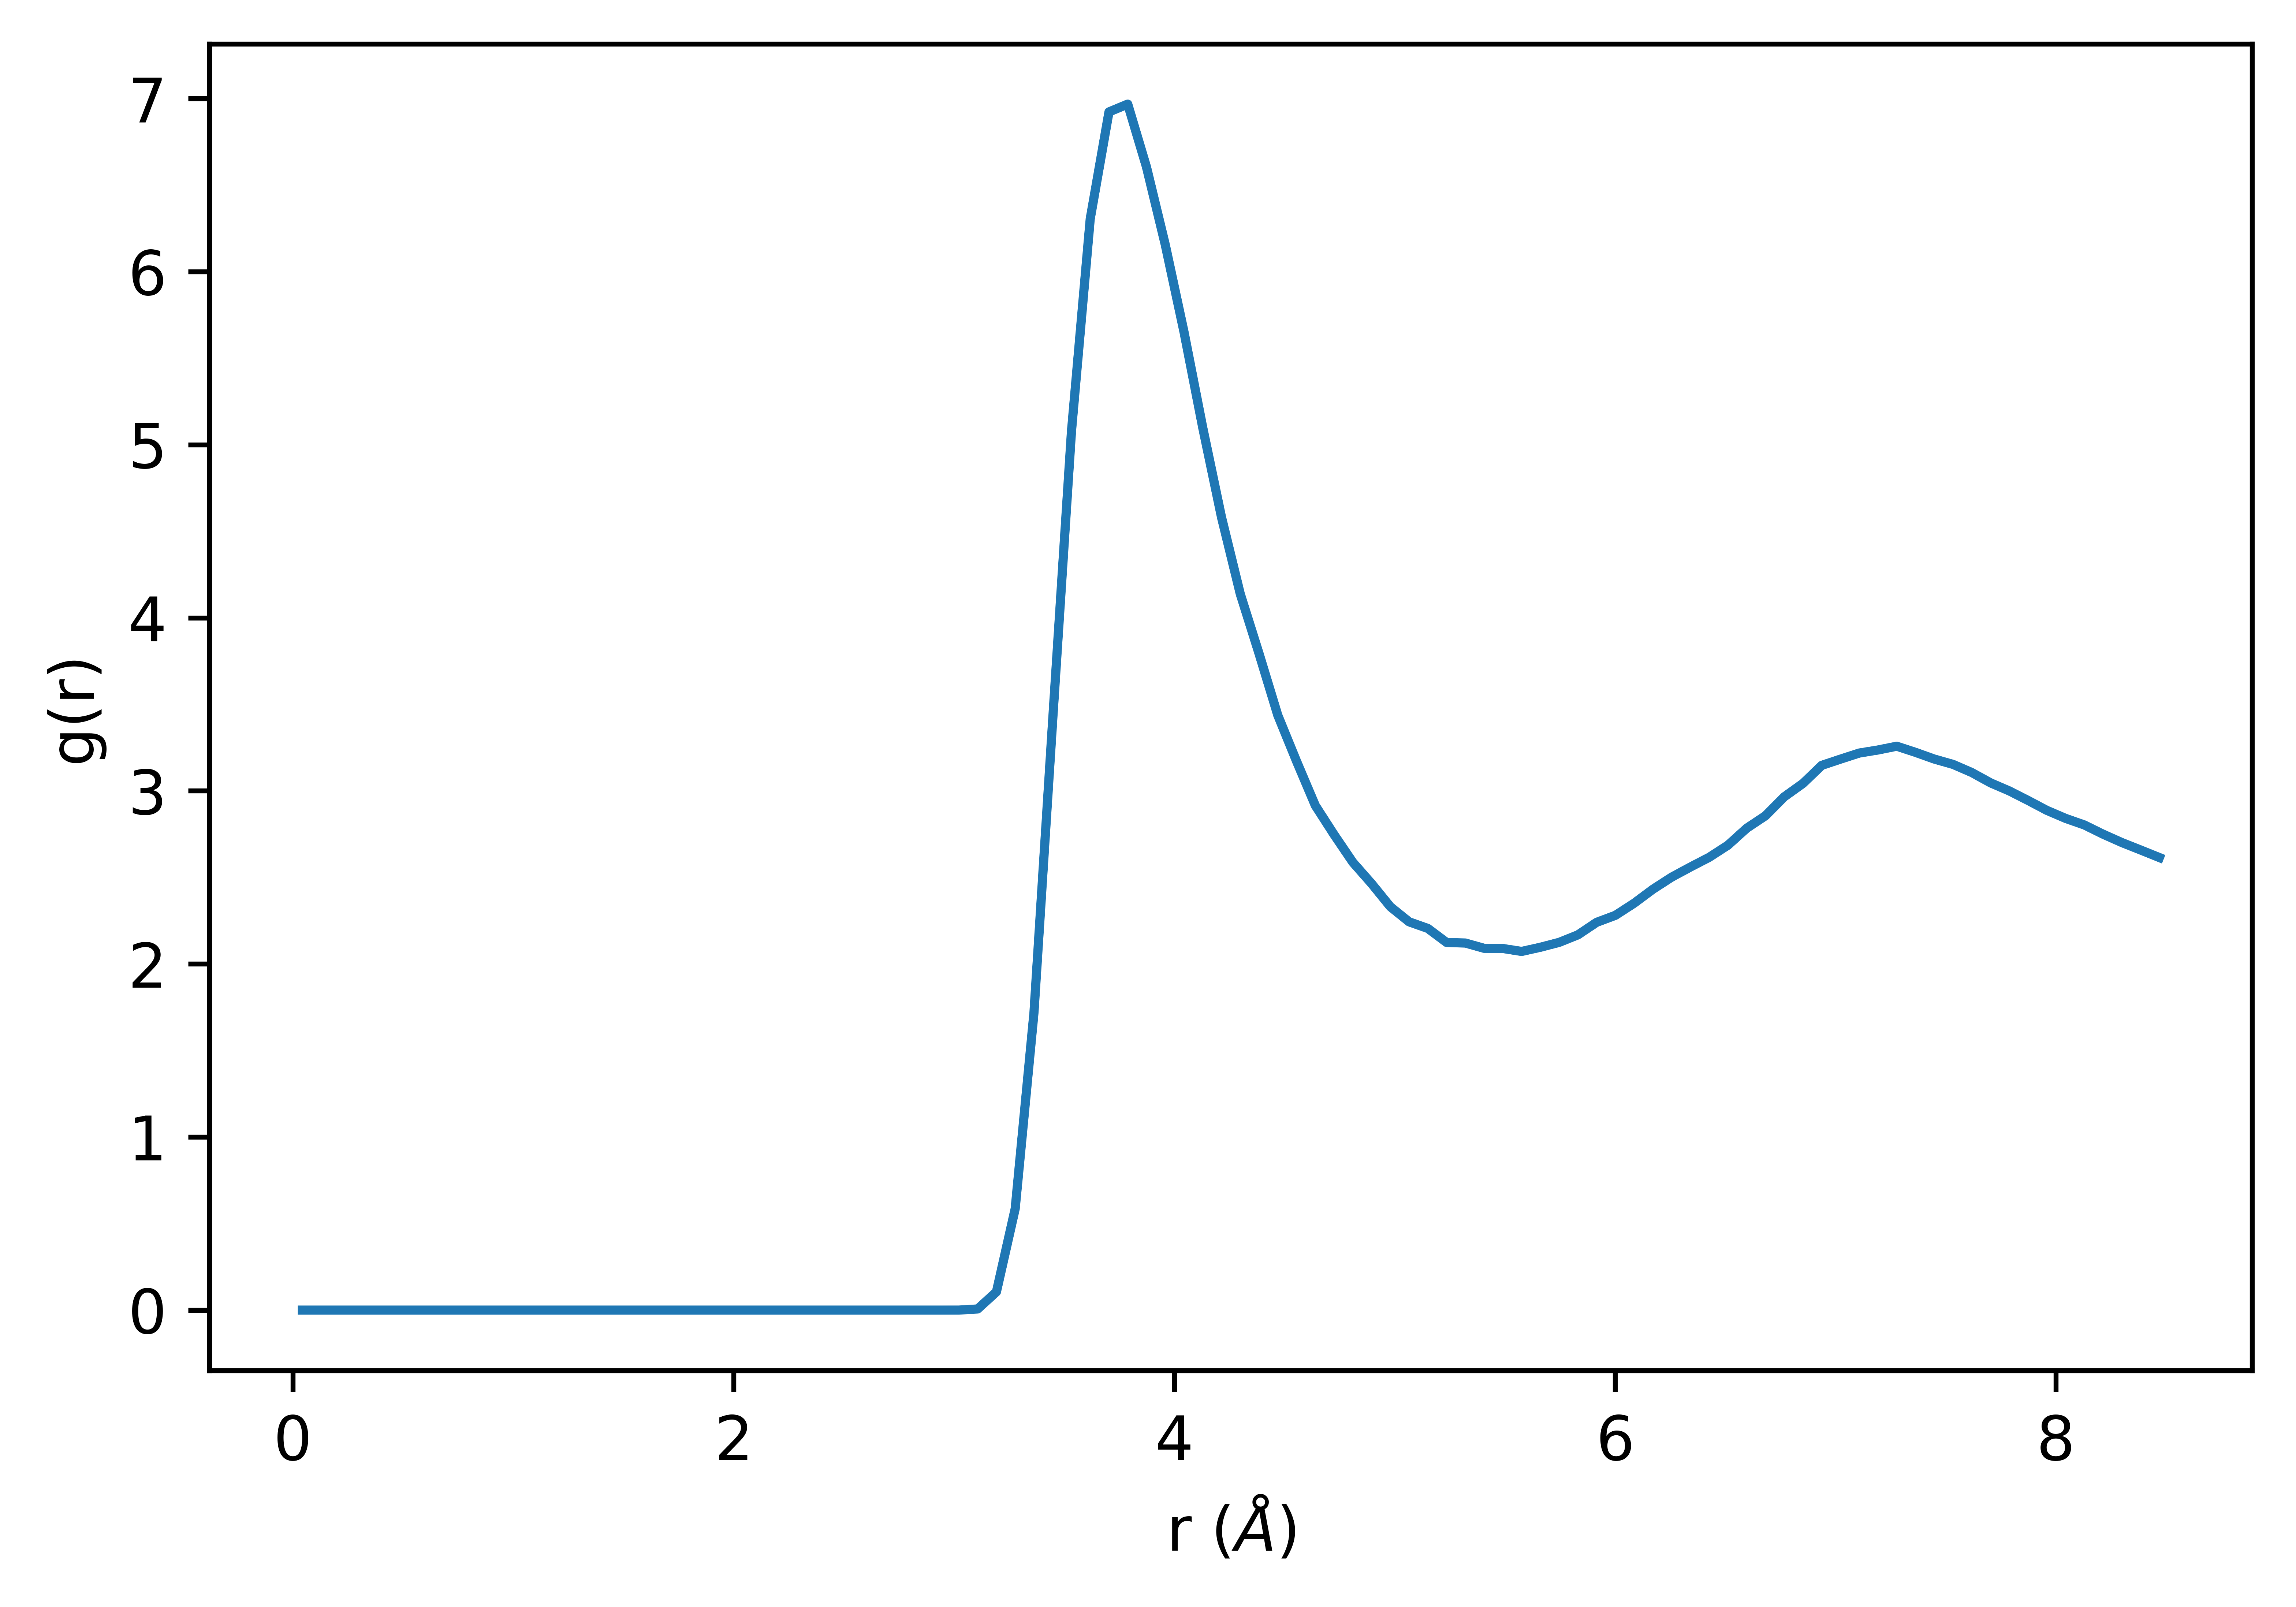

In [59]:
plt.figure(dpi=1200)
prefactor = 6.0 * Box_sizeXY**2 * Box_sizeZ / (Natoms*Natoms*(Nsteps-Nequil)*4.0*Pi)
r = np.zeros([Ngrid_rdf])
rdf2 = np.zeros([Ngrid_rdf])
for i in range(Ngrid_rdf):
    rlower = i * Dr_rdf
    rupper = rlower + Dr_rdf
    r[i]=0.5*(rlower+rupper)*Length_au2Angstrom
    normalization = prefactor / (rupper**3-rlower**3)
    rdf2[i] = rdf[i] * normalization
plt.rc('text', usetex=False)
plt.plot(r,rdf2)
plt.xlabel(r'r ($\AA$)')
plt.ylabel(r'g(r)')